In [1]:
#-------------------------Setting the randomness-----------#

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4,5,6,7"  # specify which GPU(s) to be used
import cv2 as cv2

import numpy as np
np.random.seed(1) # for reproducability

from tensorflow import set_random_seed
set_random_seed(1) # for reproducability
#------------------------------------------------------#
import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation,Reshape

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
from numpy import load
train_data = load('data/training_data_250_3channel.npy')
test_data = load('data/testing_data_250_3channel.npy')

In [3]:
def balanced(option):
    if(option=="yes"):
        training_data = np.concatenate((train_data[0:1341],train_data[3875:]),axis=0)
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        return training_data,testing_data
    else:
        training_data = train_data
        testing_data = test_data
        return training_data,testing_data


In [4]:
training_data,test_data=balanced("no")
print(training_data.shape)
print(test_data.shape)

(5216, 187501)
(624, 187501)


In [5]:
X_train,X_val,Y_train,Y_val = train_test_split(training_data[0:,1:],training_data[0:,0:1],test_size=0.1,random_state = 1,shuffle=True,stratify=training_data[0:,0:1])

In [6]:
print('All (class distribution):', np.bincount(list(map(float, training_data[0:,0:1]))) / float(len(training_data)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,Y_train))) / float(len(Y_train)) * 100.0)
print('Validation (class distribution):', np.bincount(list(map(float,Y_val))) / float(len(Y_val)) * 100.0)

All (class distribution): [25.70935583 74.29064417]
Training (class distribution): [25.71367703 74.28632297]
Validation (class distribution): [25.67049808 74.32950192]


In [7]:
X_test = test_data[0:,1:]
Y_test = test_data[0:,0:1]

In [8]:
y_train_ohe = keras.utils.to_categorical(Y_train, 2)
y_test_ohe = keras.utils.to_categorical(Y_test, 2)
y_val_ohe = keras.utils.to_categorical(Y_val,2)

In [9]:
X_train = X_train.reshape(X_train.shape[0],250,250,3)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],250,250,3)
print(X_test.shape)
X_val = X_val.reshape(X_val.shape[0],250,250,3)
print(X_val.shape)

(4694, 250, 250, 3)
(624, 250, 250, 3)
(522, 250, 250, 3)


## Create Model

### Create VGG16 model
### Set convolutional layers to false(Non-trainable)
### Create FC layer with 3 layers and dropout between last 2 layers

In [10]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


def create_model():
    
    model = Sequential()
    
    model.add(VGG16(include_top=False,input_shape=(250,250,3)))
        
    for layer in model.layers:
        layer.trainable = False
    
    model.add(Flatten())
                  
    model.add(Dense(128,activation='relu'))
                  
    model.add(Dropout(0.1))
                  
    model.add(Dense(64,activation='relu'))
                  
    model.add(Dense(2,activation='softmax'))          

        
        
        print(model.summary())
        
        return model
    
    

In [11]:
model = create_model()

W0427 04:34:56.567944 140001013901120 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0427 04:34:56.591127 140001013901120 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 17,934,466
Trainable params: 3,219,778
Non-trainable params: 14,714,688
__________________________________

In [12]:
history_array = [] ## Used to get callbacks for 10 models
accuracy = [] ## Compute the accuracy from 10 models
model_array = [] # Save 10 models to array to be used for computing the test and returning predictions which are for printing confusion matrix
for i in range(0,5):
    model = create_model()  
    opt = optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    np.random.seed(1) # for reproducability
    #shuffle= false needs to be used if u want results to be the same every time
    history = model.fit(X_train, y_train_ohe,shuffle=True,batch_size=64,epochs=20,validation_data=(X_val, y_val_ohe))# model
    model_array.append(model)
    history_array.append(history)
    score = model.evaluate(X_test, y_test_ohe)
    accuracy.append(score)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 17,934,466
Trainable params: 3,219,778
Non-trainable params: 14,714,688
__________________________________

W0427 04:35:02.249133 140001013901120 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 4694 samples, validate on 522 samples
Epoch 1/20
4694/4694 [==============================] - 25s 5ms/step - loss: 0.2013 - accuracy: 0.9186 - val_loss: 0.0760 - val_accuracy: 0.9732
Epoch 2/20
4694/4694 [==============================] - 20s 4ms/step - loss: 0.0800 - accuracy: 0.9725 - val_loss: 0.0486 - val_accuracy: 0.9789
Epoch 3/20
4694/4694 [==============================] - 22s 5ms/step - loss: 0.0573 - accuracy: 0.9810 - val_loss: 0.0361 - val_accuracy: 0.9885
Epoch 4/20
4694/4694 [==============================] - 20s 4ms/step - loss: 0.0417 - accuracy: 0.9864 - val_loss: 0.0330 - val_accuracy: 0.9904
Epoch 5/20
4694/4694 [==============================] - 20s 4ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0286 - val_accuracy: 0.9885
Epoch 6/20
4694/4694 [==============================] - 21s 4ms/step - loss: 0.0265 - accuracy: 0.9932 - val_loss: 0.0307 - val_accuracy: 0.9904
Epoch 7/20
4694/4694 [==============================] - 21s 4ms/step - loss: 0.0241

Train on 4694 samples, validate on 522 samples
Epoch 1/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.1632 - accuracy: 0.9382 - val_loss: 0.0697 - val_accuracy: 0.9693
Epoch 2/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0663 - accuracy: 0.9757 - val_loss: 0.0402 - val_accuracy: 0.9866
Epoch 3/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0479 - accuracy: 0.9844 - val_loss: 0.0337 - val_accuracy: 0.9866
Epoch 4/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0345 - accuracy: 0.9891 - val_loss: 0.0320 - val_accuracy: 0.9866
Epoch 5/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0286 - accuracy: 0.9921 - val_loss: 0.0308 - val_accuracy: 0.9847
Epoch 6/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0181 - accuracy: 0.9953 - val_loss: 0.0265 - val_accuracy: 0.9885
Epoch 7/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0168

Train on 4694 samples, validate on 522 samples
Epoch 1/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.1632 - accuracy: 0.9382 - val_loss: 0.0697 - val_accuracy: 0.9693
Epoch 2/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0663 - accuracy: 0.9757 - val_loss: 0.0402 - val_accuracy: 0.9866
Epoch 3/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0479 - accuracy: 0.9844 - val_loss: 0.0337 - val_accuracy: 0.9866
Epoch 4/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0345 - accuracy: 0.9891 - val_loss: 0.0320 - val_accuracy: 0.9866
Epoch 5/20
4694/4694 [==============================] - 16s 3ms/step - loss: 0.0286 - accuracy: 0.9921 - val_loss: 0.0308 - val_accuracy: 0.9847
Epoch 6/20
4694/4694 [==============================] - 16s 3ms/step - loss: 0.0181 - accuracy: 0.9953 - val_loss: 0.0265 - val_accuracy: 0.9885
Epoch 7/20
4694/4694 [==============================] - 17s 4ms/step - loss: 0.0168

In [18]:
print(accuracy)

[[1.5530253318028757, 0.7419871687889099], [1.8010008250176632, 0.7371794581413269], [1.801052838306042, 0.7371794581413269], [1.6164535023826538, 0.7435897588729858], [1.8010007518491409, 0.7371794581413269]]


[0.9186195, 0.9725181, 0.98103964, 0.98636556, 0.9880699, 0.9931828, 0.99296975, 0.9955262, 0.99637836, 0.99850875, 0.9987218, 0.99850875, 0.99957395, 0.99957395, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9731800556182861, 0.9789271950721741, 0.9885057210922241, 0.99042147397995, 0.9885057210922241, 0.99042147397995, 0.992337167263031, 0.99042147397995, 0.99042147397995, 0.99042147397995, 0.9885057210922241, 0.99042147397995, 0.992337167263031, 0.99042147397995, 0.992337167263031, 0.992337167263031, 0.99042147397995, 0.9942528605461121, 0.992337167263031, 0.992337167263031]


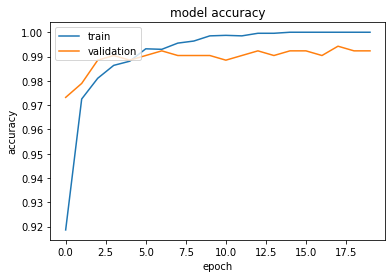

[0.938219, 0.9757137, 0.98444825, 0.9891351, 0.9921176, 0.99531317, 0.9959523, 0.99701744, 0.9982957, 0.99957395, 0.99936086, 0.99957395, 1.0, 0.999787, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.969348669052124, 0.9865900278091431, 0.9865900278091431, 0.9865900278091431, 0.984674334526062, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.9885057210922241, 0.992337167263031, 0.9885057210922241, 0.992337167263031, 0.9865900278091431, 0.99042147397995, 0.9885057210922241, 0.9865900278091431, 0.992337167263031]


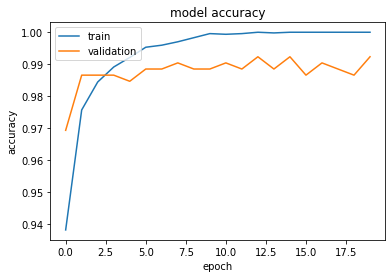

[0.938219, 0.9757137, 0.98444825, 0.9891351, 0.9921176, 0.99531317, 0.9959523, 0.99701744, 0.9982957, 0.99957395, 0.99936086, 0.99957395, 1.0, 0.999787, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.969348669052124, 0.9865900278091431, 0.9865900278091431, 0.9865900278091431, 0.984674334526062, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.9885057210922241, 0.992337167263031, 0.9885057210922241, 0.992337167263031, 0.9865900278091431, 0.99042147397995, 0.9885057210922241, 0.9885057210922241, 0.992337167263031]


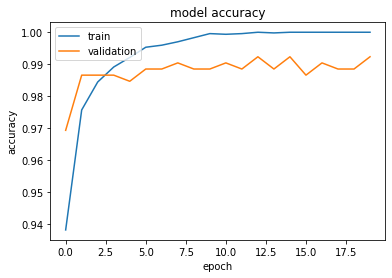

[0.93779296, 0.9748615, 0.9838091, 0.9904133, 0.9921176, 0.99616534, 0.99701744, 0.99701744, 0.9989348, 0.99957395, 0.99936086, 0.99936086, 0.999787, 0.999787, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.975095808506012, 0.9865900278091431, 0.9865900278091431, 0.9885057210922241, 0.9885057210922241, 0.9885057210922241, 0.984674334526062, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.99042147397995, 0.9885057210922241, 0.992337167263031, 0.9885057210922241, 0.992337167263031, 0.9885057210922241, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.99042147397995]


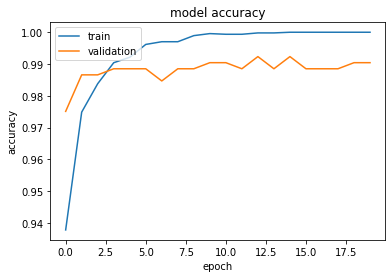

[0.938219, 0.9757137, 0.98444825, 0.9891351, 0.9921176, 0.99531317, 0.9959523, 0.99701744, 0.9982957, 0.99957395, 0.99936086, 0.99957395, 1.0, 0.999787, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.969348669052124, 0.9865900278091431, 0.9865900278091431, 0.9865900278091431, 0.984674334526062, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.9885057210922241, 0.9885057210922241, 0.99042147397995, 0.9885057210922241, 0.992337167263031, 0.9885057210922241, 0.992337167263031, 0.9865900278091431, 0.99042147397995, 0.9885057210922241, 0.9865900278091431, 0.992337167263031]


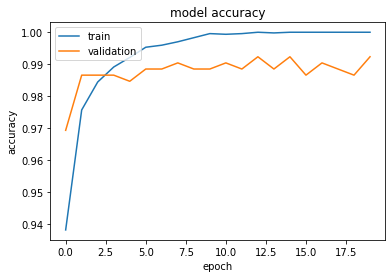

In [19]:

import matplotlib.pyplot as plt
count = 0; 


for i in history_array:
    print(i.history['accuracy'])
    plt.plot(i.history['accuracy'])
    print(i.history['val_accuracy'])
    plt.plot(i.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    name = 'train_vs_validation_accuracy' + str(count) + '.png'
    #plt.savefig('experiment2/'+name)
    plt.show()



[0.20134920743700796, 0.08001012565876811, 0.05731263945357732, 0.041677639132796526, 0.03728869197827466, 0.02649145710516545, 0.02410575797448818, 0.018781633998124898, 0.014958677346757437, 0.010957559925223482, 0.00990506815896689, 0.008250105128033087, 0.005654658449926419, 0.005319413104823512, 0.0037242875687030397, 0.003812608982185969, 0.002863086738616139, 0.001946074773728511, 0.001636744795099669, 0.001794318419617879]
[0.07598342372539857, 0.04864955445130666, 0.03607127501475857, 0.03296525635082146, 0.028640883621470683, 0.03071366377545956, 0.02608375946395242, 0.026832066733261634, 0.022281201449276387, 0.02257710225680322, 0.024019276901679935, 0.0199063905868037, 0.029664288870847544, 0.018873587735996393, 0.021764477543618488, 0.019999646813647957, 0.018961569572659744, 0.019472228448795176, 0.019762968815777493, 0.02306925717355876]


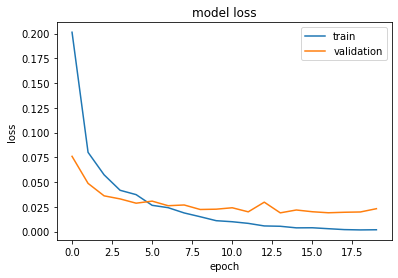

[0.16315171698724965, 0.06630862494402863, 0.04793690049700982, 0.0345365541142304, 0.028573913090200846, 0.018134970230641242, 0.016792905415536484, 0.013446727726566056, 0.009569567130600004, 0.0060531894239296636, 0.0058963990381005775, 0.004963548430518422, 0.003923183690671641, 0.003364140673968695, 0.0024535443400567325, 0.0018116820816499824, 0.0016979169787432915, 0.0011919930215284521, 0.0009132871546349629, 0.0008612794001026682]
[0.0696603365213935, 0.04016139966317977, 0.033677770745480194, 0.03199760236160052, 0.030790760313870805, 0.02651907042582373, 0.027847592972247537, 0.025457358465911784, 0.02200714739260774, 0.021745005401272426, 0.022727731315568947, 0.021876660407560082, 0.031861552438730824, 0.021030987174003975, 0.02578238716841429, 0.02365187404256214, 0.02440796224436084, 0.023547953098184533, 0.0231565999302485, 0.029251973191097777]


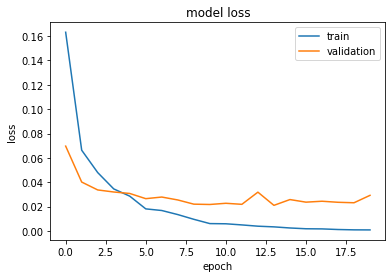

[0.16315171603807044, 0.06630862554401147, 0.04793690221204014, 0.034536552953946115, 0.028573912956871325, 0.018134971013158547, 0.01679290399335493, 0.013446727009126254, 0.00956956636990747, 0.006053199357177362, 0.005896400051563661, 0.004963566065902024, 0.0039231920651345495, 0.0033641733791842632, 0.002453543843344746, 0.0018116895822291494, 0.001698700428190278, 0.001193808691942085, 0.0009134979114058643, 0.0008609969425423126]
[0.06966033355257976, 0.040161399677452914, 0.03367776879005962, 0.03199760042045308, 0.030790762654666244, 0.026519072324151738, 0.027847596040973262, 0.02545735288511291, 0.022007138421937425, 0.021745010325506728, 0.022727760190137045, 0.021876707887169958, 0.031861613213773315, 0.02103098092236738, 0.025782396660054323, 0.02365192919398633, 0.02442561889288526, 0.023551405785726634, 0.023161671135103565, 0.02925802637034335]


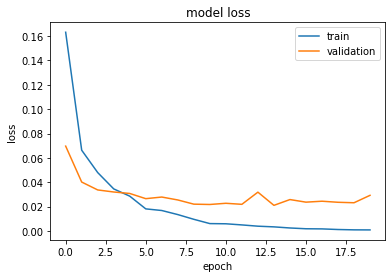

[0.15921517180593966, 0.06379557211106007, 0.04555234932517264, 0.03166902537009642, 0.025956430338310417, 0.017119568623808732, 0.015397550596017906, 0.011757476701564662, 0.008367684508686147, 0.005519575000417978, 0.005223271519129815, 0.0050738579864424435, 0.004032282029371034, 0.0028729708686718596, 0.0025505014550588423, 0.0022267143286305905, 0.0016882618438630254, 0.0012976406731384457, 0.001169440613898461, 0.0010233015135532727]
[0.06297214049489105, 0.04827313904447117, 0.03196017368486101, 0.028071784196685556, 0.027787830266687606, 0.025389149028565237, 0.029667119156583516, 0.02309022726797966, 0.022098189326880992, 0.021971314617386266, 0.023515077471961465, 0.02089908753318348, 0.03218673821895515, 0.0196908345139118, 0.023849007555808144, 0.02268786985298683, 0.022755589075671986, 0.02278269885885761, 0.022828497599196616, 0.024811687629484352]


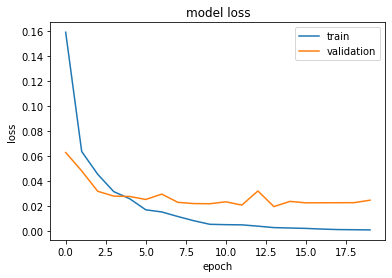

[0.1631517159523586, 0.06630862455673811, 0.04793690024384246, 0.03453655329044443, 0.028573914271119456, 0.018134969452885705, 0.016792906069486038, 0.013446728012272171, 0.009569567138536286, 0.006053189577893515, 0.005896399641257933, 0.004963548391630645, 0.003923183781145244, 0.0033641406709925895, 0.0024535437400738896, 0.0018116820753009575, 0.001697916550184118, 0.0011919923441668693, 0.0009132873018529754, 0.0008612798310427261]
[0.0696603369210415, 0.04016140261772035, 0.033677769246800195, 0.031997601862040516, 0.03079076159845367, 0.026519072923623738, 0.027847599951814416, 0.025457351529164333, 0.022007145965293448, 0.021745010339779873, 0.02272773134411523, 0.021876663083774377, 0.03186155320948054, 0.02103098740237426, 0.02578238318620742, 0.023651871159387276, 0.024407955193428244, 0.023547949540603665, 0.023156598595709635, 0.029251974115283783]


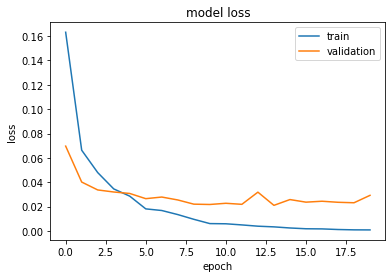

In [20]:

count = 0 
for i in history_array:
    print(i.history['loss'])
    plt.plot(i.history['loss'])
    plt.plot(i.history['val_loss'])
    print(i.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    name = 'train_vs_test_loss_shuffled_btch32_' + str(count) + '.png'
    #plt.savefig(name)
    count = count +1
    plt.show()    
    
  

In [16]:
from sklearn.metrics import confusion_matrix
def classification_report():
    
    for i in model_array:
        y_pred = i.predict_classes(X_test)
        matrix = ["TN","FP"],["FN","TP"]
        print(matrix[0])
        print(matrix[1])

        ##Lets Visualise the output
        conf=confusion_matrix(Y_test, y_pred)
        print("Confusion Matrix")
        print(conf)
        # or we can use a heatmap from the seaborn library
        #import seaborn as sn
        #df_cm = pandas.DataFrame(conf, range(2), range(2))
        #sn.set(font_scale=1.4)#for label size
        #sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 20},fmt="d")# font size

        from sklearn.metrics import classification_report
        print(classification_report(Y_test,y_pred));
        



In [17]:
classification_report()

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 74 160]
 [  1 389]]
              precision    recall  f1-score   support

         0.0       0.99      0.32      0.48       234
         1.0       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.66      0.65       624
weighted avg       0.81      0.74      0.70       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 71 163]
 [  1 389]]
              precision    recall  f1-score   support

         0.0       0.99      0.30      0.46       234
         1.0       0.70      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.64       624
weighted avg       0.81      0.74      0.69       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 71 163]
 [  1 389]]
              precision    recall  f1-score   support

         0.0       0.99      0.30      0.46       234
         1.0       0.70      1.00      